# Подключение библиотек

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import silhouette_score
import re
import chardet
import codecs
import pickle

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score,log_loss
from sklearn.utils.class_weight import compute_class_weight
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, GRU, Embedding, Bidirectional,Dropout,TimeDistributed,Activation,BatchNormalization

In [ ]:
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DIR='/content/drive/MyDrive/Тест/'

# Анализ базы

In [ ]:
work_base=pd.read_csv(DIR+'part_10.csv')

In [ ]:
print(work_base.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57845 entries, 0 to 57844
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CLIENT_IP               57838 non-null  object
 1   CLIENT_USERAGENT        57517 non-null  object
 2   REQUEST_SIZE            57794 non-null  object
 3   RESPONSE_CODE           57770 non-null  object
 4   MATCHED_VARIABLE_SRC    57730 non-null  object
 5   MATCHED_VARIABLE_NAME   53167 non-null  object
 6   MATCHED_VARIABLE_VALUE  57683 non-null  object
 7   EVENT_ID                57666 non-null  object
dtypes: object(8)
memory usage: 3.5+ MB
None


In [ ]:
work_base.fillna("Unknown", inplace=True)

In [ ]:
def get_encoding(value):
    try:
        result = chardet.detect(value.encode())
        if result['confidence'] >= 0.5:
            return result['encoding']
        else:
            return "неизвестная кодировка"
    except:
        return "неизвестная кодировка"

work_base['CLIENT_ID_encoding'] =work_base['CLIENT_IP'].apply(get_encoding)

In [ ]:
categories = [
    {'name': 'IP Address', 'regex': r'\b(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\b'},
    {'name': 'IPv6 Address', 'regex': r'^([0-9A-Fa-f]{1,4}:){7}[0-9A-Fa-f]{1,4}|((^|:)([0-9A-Fa-f]{0,4})){1,8}(:|$)'},
    {'name': 'Remote Code Execution', 'regex': r'Remote Code Execution'},
    {'name': 'SQL Injection', 'regex': r'SQL Injection'},
    {'name': 'Cross-Site Scripting', 'regex': r'Cross-Site Scripting'},
    {'name': 'SQL Injection User-Agent', 'regex': r'SQL Injection', 'column': 'CLIENT_USERAGENT'},
    {'name': 'Cross-Site Scripting User-Agent', 'regex': r'Cross-Site Scripting', 'column': 'CLIENT_USERAGENT'}]

clean_data = work_base
for cat in categories:
    regex = cat['regex']
    column = cat.get('column', 'CLIENT_IP')
    name = cat['name']
    regex_mask = clean_data[column].str.contains(regex, regex=True)
    matched_data = clean_data[regex_mask]
    unmatched_data = clean_data[~regex_mask]
    clean_data = unmatched_data
    if name == categories[0]['name']:
        result_df = matched_data
    else:
        result_df = pd.merge(result_df, matched_data, how='outer')

<ipython-input-12-920b6b4132c9>:15: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  regex_mask = clean_data[column].str.contains(regex, regex=True)


In [ ]:
result_df.reset_index(drop= True , inplace= True )

In [ ]:
clean_data_n=clean_data[clean_data['CLIENT_IP']!='Unknown']
clean_data_n["CLIENT_IP"].value_counts().loc[lambda x: x > 2]

f~|°ØÀ¶
g8%ú·P:V­    5
Name: CLIENT_IP, dtype: int64

In [ ]:
print(result_df.describe())

             CLIENT_IP                                   CLIENT_USERAGENT  \
count            57794                                              57794   
unique           24902                                               6976   
top     217.175.140.69  Mozilla/5.0 (Windows NT 6.1; WOW64; Trident/7....   
freq             11286                                               2117   

       REQUEST_SIZE RESPONSE_CODE MATCHED_VARIABLE_SRC MATCHED_VARIABLE_NAME  \
count         57794         57794                57794                 57794   
unique         5758            61                   22                  3210   
top             259           200     REQUEST_GET_ARGS    REQUEST_GET_ARGS._   
freq            261         25771                20812                 11165   

       MATCHED_VARIABLE_VALUE EVENT_ID CLIENT_ID_encoding  
count                   57794    57794              57794  
unique                  57612    54411                  5  
top                   Unknown  Un

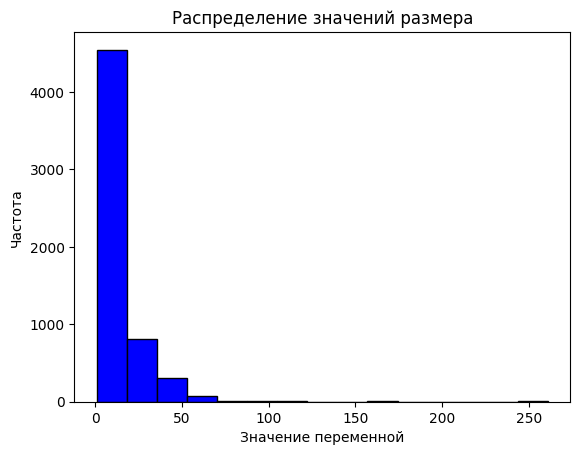

In [ ]:
plt.hist(result_df["REQUEST_SIZE"].value_counts(),bins=15, color='blue', edgecolor='black')
plt.xlabel('Значение переменной')
plt.ylabel('Частота')
plt.title('Распределение значений размера')
plt.show()

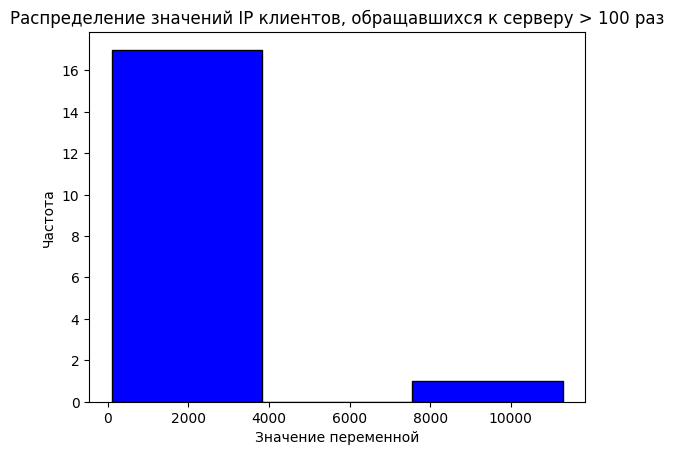

In [ ]:
plt.hist(result_df["CLIENT_IP"].value_counts().loc[lambda x: x > 100],bins=3, color='blue', edgecolor='black')
plt.xlabel('Значение переменной')
plt.ylabel('Частота')
plt.title('Распределение значений IP клиентов, обращавшихся к серверу > 100 раз')
plt.show()

In [ ]:
print("Таблица частот IP клиентов")
result_df["CLIENT_IP"].value_counts()

Таблица частот IP клиентов


217.175.140.69                    11286
37.46.129.136                       771
188.43.52.163                       767
5.143.231.38                        757
192.168.100.63                      748
                                  ...  
185.23.66.47                          1
54.36.150.65                          1
2.61.103.153                          1
178.129.255.160                       1
Á5ÎBÒÀìv|¤m*Ýí^¬±yº¿0Gåÿ        1
Name: CLIENT_IP, Length: 24902, dtype: int64

In [ ]:
print("Таблица частот ответа сервера")
result_df["RESPONSE_CODE"].value_counts()

Таблица частот ответа сервера


200                                 25771
404                                 20367
302                                  6630
403                                  1156
304                                   940
                                    ...  
df913ceca75a4cc24ee0afbc2f22ceaf        1
0b809ae29d22329a1ca3353f675e3dcf        1
1afd3c172028bc84840929251e10a8f9        1
82b4c42ac7edc647d27de21ceb791491        1
be917628f6edcdc86d6bdea6edab6c48        1
Name: RESPONSE_CODE, Length: 61, dtype: int64

In [ ]:
result_df["CLIENT_IP"].value_counts().loc[lambda x: x > 100]

217.175.140.69     11286
37.46.129.136        771
188.43.52.163        767
5.143.231.38         757
192.168.100.63       748
185.26.112.50        687
62.168.244.229       542
103.208.220.130      303
185.70.104.11        280
178.236.141.227      214
77.221.130.13        166
217.175.155.82       126
217.175.155.123      120
217.175.155.124      119
188.191.21.201       117
95.188.66.154        106
95.161.153.34        105
172.31.1.19          101
Name: CLIENT_IP, dtype: int64

In [ ]:
control_test=result_df.loc[[random.randint(0,len(result_df)), random.randint(0,len(result_df)), random.randint(0,len(result_df)),57748], :]
merged_base= result_df.merge(control_test, how='outer', indicator=True)
result_df=merged_base[merged_base['_merge'] == 'left_only'].drop(columns=['_merge'])

In [ ]:
control_test.to_csv(DIR+'control_test.csv')
features = ['CLIENT_IP', 'CLIENT_USERAGENT','REQUEST_SIZE','RESPONSE_CODE']
data_base=result_df[features]
data_base.head()

,CLIENT_IP,CLIENT_USERAGENT,REQUEST_SIZE,RESPONSE_CODE
0,188.138.92.55,Unknown,166,404
1,93.158.215.131,Mozilla/5.0 (Windows NT 6.3; WOW64; rv:45.0) G...,431,302
2,176.123.240.64,Mozilla/5.0 (Windows NT 6.0; rv:34.0) Gecko/20...,395,403
3,73.78.81.63,Mozilla/5.0 (Windows NT 6.3; WOW64; rv:45.0) G...,387,302
4,66.102.9.44,Mozilla/5.0 (Linux; Android 4.4.2; GT-N7100 Bu...,1733,404


Выводы:


*   Большинство запросов имели размер от 0 до 100
*   Большинство RESPONSE_CODE соответствуют успешным запросам (код 200), но есть также и ошибки (коды 400, 404, 500)
*  В CLIENT_IP присутствуют клиенты, обратившиеся к серверу более 100 раз, но в их поведении не обнаружились аномалии
*  В данных были найдены 44  записи, декодировать и/или определить кодировку которых не удается. При этом 9 из 44 записей подключались к системе 2 и более раз. Дополнительная информация по данным записям отсутствует, допускаю, что это могут быть ошибки логирования
*   MATCHED_VARIABLE_SRC, MATCHED_VARIABLE_NAME, MATCHED_VARIABLE_VALUE: эти атрибуты представляют собой дополнительные данные, которые использовались при сопоставлении запросов в логах и не содержат непосредственно информации о клиенте или сервере.



# Препроцессинг

In [ ]:
data_base_sc=data_base.copy()

In [ ]:
factor_dict={}
features = ['CLIENT_IP', 'CLIENT_USERAGENT','REQUEST_SIZE','RESPONSE_CODE']
for f in features:
  data_base_sc[f],factor = pd.factorize(data_base_sc[f])
  data_base_sc[f] = pd.Categorical(data_base_sc[f])
  factor_dict[f] = {'factors': pd.Categorical(data_base_sc[f]), 'categories': factor}

In [ ]:
#стандартизация
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data_base_sc)

# Подбор модели

## Кластеризация DBSCAN

In [ ]:
eps_list = [0.5, 1.0, 1.5]
min_samples_list = [3, 5, 10]
results = {'eps': [], 'min_samples': [], 'n_clusters': [], 'silhouette_score': []}

for eps in eps_list:
  for min_samples in min_samples_list:
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(X_scaled)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    if n_clusters > 1:
      silhouette = silhouette_score(X_scaled, labels)
    else:
      silhouette = float('nan')
    results['eps'].append(eps)
    results['min_samples'].append(min_samples)
    results['n_clusters'].append(n_clusters)
    results['silhouette_score'].append(silhouette)


comparison_table = pd.DataFrame(results)

In [ ]:
comparison_table.sort_values('silhouette_score',ascending=False)

,eps,min_samples,n_clusters,silhouette_score
8,1.5,10,2,0.757462
5,1.0,10,2,0.754205
6,1.5,3,2,0.689981
7,1.5,5,2,0.689981
4,1.0,5,2,0.593739
3,1.0,3,4,0.388733
2,0.5,10,10,0.366596
0,0.5,3,30,0.145065
1,0.5,5,17,0.108383


In [ ]:
dbscan = DBSCAN(eps=0.5, min_samples=3)
dbscan.fit(X_scaled)

DBSCAN(min_samples=3)

In [ ]:
analise=data_base.copy()
label = dbscan.labels_
analise['cluster'] = label

for i in range(-1, max(label)+1):
  print('\nCluster', i)
  cluster_data = analise[analise['cluster'] == i]
  print(cluster_data.describe())


Cluster -1
       cluster
count    253.0
mean      -1.0
std        0.0
min       -1.0
25%       -1.0
50%       -1.0
75%       -1.0
max       -1.0

Cluster 0
       cluster
count  57295.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0

Cluster 1
       cluster
count      6.0
mean       1.0
std        0.0
min        1.0
25%        1.0
50%        1.0
75%        1.0
max        1.0

Cluster 2
       cluster
count      3.0
mean       2.0
std        0.0
min        2.0
25%        2.0
50%        2.0
75%        2.0
max        2.0

Cluster 3
       cluster
count      3.0
mean       3.0
std        0.0
min        3.0
25%        3.0
50%        3.0
75%        3.0
max        3.0

Cluster 4
       cluster
count      5.0
mean       4.0
std        0.0
min        4.0
25%        4.0
50%        4.0
75%        4.0
max        4.0

Cluster 5
       cluster
count      7.0
mean       5.0
std        0.0
min        5.0
25%        5.0
50%        5.0
75%    

In [ ]:
analise[analise['cluster']==29]

,CLIENT_IP,CLIENT_USERAGENT,REQUEST_SIZE,RESPONSE_CODE,cluster
57730,Remote Code Execution,AVdtgf8uq1Ppo9zF_hyd,4df2f46285c84ba39fa84fc4878214ae,Unknown,29
57731,Remote Code Execution,AVddr1QQq1Ppo9zF3Vuj,0b168993dda4ce786f3455d01e162a58,Unknown,29
57732,Remote Code Execution,AVddRtA4q1Ppo9zF3E0u,f44ca434dfc32f17dff464956033f461,Unknown,29
57733,Remote Code Execution,AVdrihgNq1Ppo9zF-n8K,47dcc12389bccd49ba2a60b2e0a56e98,Unknown,29
57734,Remote Code Execution,AVdh6mHyq1Ppo9zF5Zg-,57e7c5ef3f48e338deff1b3ff9d91b26,Unknown,29
...,...,...,...,...,...
57789,I·`)ó>ïï #��é=AþyÒzþü ëVEݴG>E¼É!õý¿=Àûg...,Cross-Site Scripting,AVdXQUGaq1Ppo9zFznch,1f71588787ee4ee0ef301328471e64e9,29
57790,?{7?¹۱V>F¢¾ºþÀÒûÛÿ,Cross-Site Scripting,AVdbqa9jq1Ppo9zF2FKr,63efc61a61cb360cf4bc705e86d9f31f,29
57791,]övêÌ=¼¯³·Wø a©Éc½vQù*N9õÎ^ù´ÿ,Cross-Site Scripting,AVdZlemoq1Ppo9zF1Btr,d64bdad286ae021642535d4f119a0546,29
57792,r®\t÷À5ÞbØÿ,Cross-Site Scripting,AVdbxeDNq1Ppo9zF2JJA,50a68d94b153e22135f74f7377b95cda,29


In [ ]:
subset = analise[analise['cluster'] != 0]

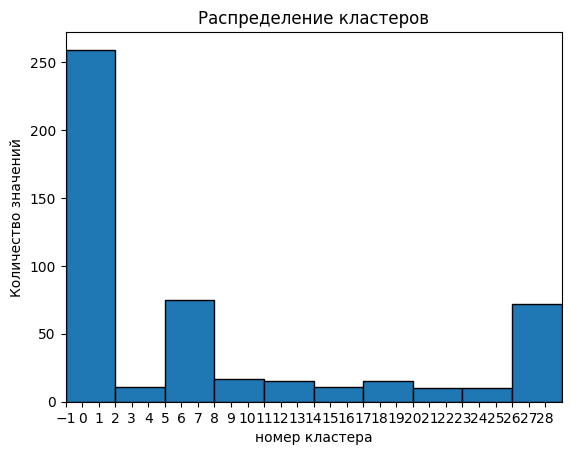

In [ ]:
plt.hist(subset['cluster'], edgecolor='black')
plt.xticks(range(-1,29, 1))
plt.xlim(-1,29)
plt.xlabel('номер кластера')
plt.ylabel('Количество значений')
plt.title('Распределение кластеров')
plt.show()

## Кластеризация K-Means

In [ ]:
results = {'n_clusters': [], 'silhouette_score': []}
for n_cluster in range(2,50):
  kmeans = KMeans(n_clusters=n_cluster, init='k-means++', max_iter=300, n_init=10, random_state=0)
  labels = kmeans.fit_predict(X_scaled)
  silhouette = silhouette_score(X_scaled, labels)
  results['n_clusters'].append(n_cluster)
  results['silhouette_score'].append(silhouette)

comparison_table = pd.DataFrame(results)

In [ ]:
comparison_table.sort_values('silhouette_score',ascending=False)

,n_clusters,silhouette_score
3,5,0.385778
2,4,0.371962
16,18,0.341683
21,23,0.340011
0,2,0.338410
20,22,0.337062
4,6,0.336868
22,24,0.336439
9,11,0.334519
6,8,0.334447


In [ ]:
kmeans = KMeans(n_clusters=30, init='k-means++', max_iter=300, n_init=10, random_state=0)
kmeans.fit(X_scaled)

KMeans(n_clusters=30, n_init=10, random_state=0)

In [ ]:
kmeans.labels_

array([25, 25, 13, ..., 12, 12, 12], dtype=int32)

In [ ]:
analise_kmeans=data_base.copy()
label = kmeans.labels_
analise_kmeans['cluster'] = label

for i in range(-1, max(label)+1):
  print('\nCluster', i)
  cluster_data = analise_kmeans[analise_kmeans['cluster'] == i]
  print(cluster_data.describe())


Cluster -1
       cluster
count      0.0
mean       NaN
std        NaN
min        NaN
25%        NaN
50%        NaN
75%        NaN
max        NaN

Cluster 0
       cluster
count   5508.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0

Cluster 1
       cluster
count   1851.0
mean       1.0
std        0.0
min        1.0
25%        1.0
50%        1.0
75%        1.0
max        1.0

Cluster 2
       cluster
count   3537.0
mean       2.0
std        0.0
min        2.0
25%        2.0
50%        2.0
75%        2.0
max        2.0

Cluster 3
       cluster
count    656.0
mean       3.0
std        0.0
min        3.0
25%        3.0
50%        3.0
75%        3.0
max        3.0

Cluster 4
       cluster
count   2575.0
mean       4.0
std        0.0
min        4.0
25%        4.0
50%        4.0
75%        4.0
max        4.0

Cluster 5
       cluster
count    279.0
mean       5.0
std        0.0
min        5.0
25%        5.0
50%        5.0
75%    

In [ ]:
analise_kmeans[analise_kmeans['cluster']==28]

,CLIENT_IP,CLIENT_USERAGENT,REQUEST_SIZE,RESPONSE_CODE,cluster
10777,217.147.21.122,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,1628,404,28
10828,83.220.238.74,Mozilla/5.0 (iPhone; CPU iPhone OS 10_3_3 like...,895,404,28
10910,93.80.225.164,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_6...,1335,404,28
10978,46.4.32.75,Mozilla/5.0 (compatible; MJ12bot/v1.4.5; http:...,509,404,28
11004,213.87.157.178,Mozilla/5.0 (Linux; Android 7.0; FRD-L19 Build...,978,404,28
...,...,...,...,...,...
57304,92.39.220.107,Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:5...,1567,404,28
57343,176.59.52.120,Mozilla/5.0 (iPhone; CPU iPhone OS 11_2_2 like...,1052,404,28
57377,217.66.154.165,Mozilla/5.0 (iPhone; CPU iPhone OS 10_3_3 like...,1319,404,28
57384,109.86.177.218,Mozilla/5.0 (Windows; U; Windows NT 5.1; pt-PT...,739,302,28


## Линейная классификация

In [ ]:
y=analise['cluster']

In [ ]:
class_labels = np.unique(y)
first_class_index = np.where(class_labels==-1)[0][0]
class_weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=y)
class_weights[first_class_index] *= 0.99
class_weight_dict = dict(zip(class_labels, class_weights))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.1)

In [ ]:
model = LogisticRegression(max_iter=1000, solver='liblinear',class_weight=class_weight_dict)
LG_model=model.fit(X_train, y_train)

In [ ]:
predictions = LG_model.predict(X_test)

In [ ]:
print('Accuracy score:', accuracy_score(y_test, predictions))

Accuracy score: 0.967468420141893


In [ ]:
predict_claster = LG_model.predict(test_test)
print(predict_claster)

[ 0  0  0 22]


## Классификация K-ближайших соседей

In [ ]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.997231354905693


In [ ]:
predict_claster = knn.predict(test_test)
print(predict_claster)

[ 0  0  0 -1]


## Классификация опорных векторов

In [ ]:
svm = SVC(C=1.0, kernel='rbf', gamma='scale', class_weight='balanced')
svm.fit(X_train, y_train)

y_pred = svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9688527426890465


In [ ]:
predict_claster = svm.predict(test_test)
print(predict_claster)

[ 0  0  0 -1]


## Классификация RandomForest

In [ ]:
rfc = RandomForestClassifier()
param_grid = {'n_estimators': [10, 50, 100, 200], 'max_depth': [5, 10, 15, None],'max_features': ['sqrt', 'log2']}
grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print("Best parameters:", best_params)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Best parameters: {'max_depth': None, 'max_features': 'log2', 'n_estimators': 50}


In [ ]:
results = grid_search.cv_results_
mean_score = np.mean(results['mean_test_score'])
std_score = np.std(results['std_test_score'])
print("Mean accuracy: {:.2f} +/- {:.2f}".format(mean_score, std_score))

Mean accuracy: 1.00 +/- 0.00


In [ ]:
rfc = RandomForestClassifier(n_estimators=200)#class_weight='balanced')
rfc.fit(X_train, y_train)

accuracy = rfc.score(X_test, y_test)
print("Test accuracy model: {:.2f}".format(accuracy))

y_pred = rfc.predict(X_test)
print("Test accuracy predict: {:.2f}".format(accuracy_score(y_test, y_pred)))

Test accuracy model: 1.00
Test accuracy predict: 1.00


In [ ]:
scores = cross_val_score(rfc, X_train, y_train, cv=5)
mean_score = scores.mean()
std_score = scores.std()
print("Train accuracy cross-vall: {:.2f}".format(mean_score,std_score))

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Train accuracy cross-vall: 1.00


In [ ]:
predict_claster = rfc.predict(test_test)
print(predict_claster)

[ 0  0  0 -1]


## RNN

In [ ]:
batch_size = 32
epochs=50

In [ ]:
Y=analise['cluster']
Y_cat = tf.keras.utils.to_categorical(Y, 30)

In [ ]:
model = Sequential()
model.add(Dense(128, input_dim=4, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(30, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 128)               640       
                                                                 
 batch_normalization_6 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_12 (Dense)            (None, 30)                3870      
                                                                 
Total params: 5,022
Trainable params: 4,766
Non-trainable params: 256
_________________________________________________________________


In [ ]:
history = model.fit(X_scaled, Y_cat, epochs=epochs, batch_size=batch_size, validation_split=0.2)

Epoch 1/50
1445/1445 [==============================] - 8s 5ms/step - loss: 0.3226 - accuracy: 0.9428 - val_loss: 0.0635 - val_accuracy: 0.9886
Epoch 2/50
1445/1445 [==============================] - 5s 3ms/step - loss: 0.0284 - accuracy: 0.9943 - val_loss: 0.0720 - val_accuracy: 0.9867
Epoch 3/50
1445/1445 [==============================] - 5s 3ms/step - loss: 0.0232 - accuracy: 0.9943 - val_loss: 0.0645 - val_accuracy: 0.9894
Epoch 4/50
1445/1445 [==============================] - 6s 4ms/step - loss: 0.0204 - accuracy: 0.9950 - val_loss: 0.0630 - val_accuracy: 0.9887
Epoch 5/50
1445/1445 [==============================] - 5s 3ms/step - loss: 0.0186 - accuracy: 0.9950 - val_loss: 0.0659 - val_accuracy: 0.9881
Epoch 6/50
1445/1445 [==============================] - 5s 3ms/step - loss: 0.0182 - accuracy: 0.9952 - val_loss: 0.0794 - val_accuracy: 0.9822
Epoch 7/50
1445/1445 [==============================] - 7s 5ms/step - loss: 0.0173 - accuracy: 0.9953 - val_loss: 0.0708 - val_accuracy:

In [ ]:
score=model.evaluate(X_scaled, Y_cat,batch_size=batch_size) #X_test, y_test
print('score:',score)

1806/1806 [==============================] - 4s 2ms/step - loss: 0.0347 - accuracy: 0.9950
score: [0.03466052561998367, 0.9949818253517151]


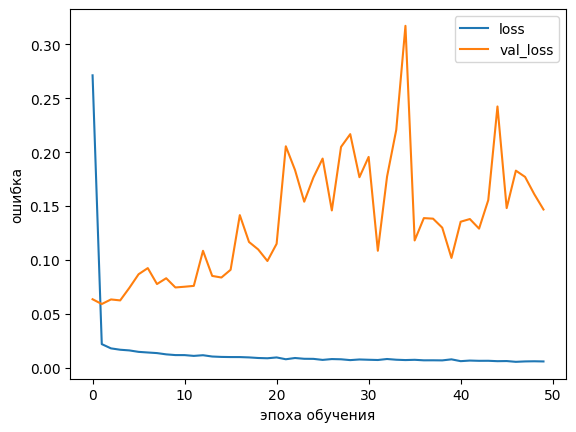

In [ ]:
plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('эпоха обучения')
plt.ylabel('ошибка')
plt.legend()
plt.show()

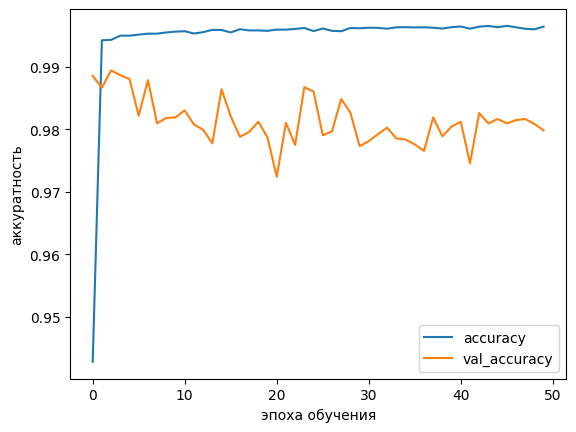

In [ ]:
plt.plot(history.history['accuracy'],label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('эпоха обучения')
plt.ylabel('аккуратность')
plt.legend()
plt.show()

In [ ]:
np.argmax(model.predict([test_test]), axis=-1)

1/1 [==============================] - 0s 37ms/step


array([ 0,  0,  0, 29])

# Сохранение модели и файлов

In [ ]:
model.save(DIR+'эталонная_модель')

In [ ]:
filename = DIR+'file_model.sav'
pickle.dump({'factor': factor_dict, 'scaler': scaler}, open(filename, 'wb'))

In [ ]:
predict_file = '''

import tensorflow as tf
import pickle
import pandas as pd
import numpy as np

loaded_model=tf.keras.models.load_model(DIR+'эталонная_модель')
loaded_data = pickle.load(open(DIR+'file_model.sav', 'rb'))

def prediction_number_claster(our_data):
  factor = loaded_data['factor']
  scaler = loaded_data['scaler']
  features = ['CLIENT_IP', 'CLIENT_USERAGENT','REQUEST_SIZE','RESPONSE_CODE']
  our_data=our_data[features]
  for f in features:
    our_data[f] = pd.Categorical(our_data[f], categories=factor[f]['categories'])
    our_data[f] = our_data[f].cat.codes
  testscaled = scaler.transform(our_data)
  predict_claster = np.argmax(loaded_model.predict([testscaled]), axis=-1)

  return predict_claster
'''


with open(DIR+'predict.py', 'w') as file:
    file.write(predict_file)